## Bayesian Three-Point Contest


This notebook explores a problem presented in STAT 415 which goes as follows:

"We have seen how to estimate a process probability $\theta$ in a Binomial situation, but what if the number of trials is also random? For example, suppose we want to estimate both the average number of three point shots Steph Curry attempts per game ($\lambda$) and the probability of success on a single attempt ($\theta$)." 

To answer this question, this notebook will utilize Bayesian statistical techniques and the Symbulate python package. Documentation on the package is available here: https://dlsun.github.io/symbulate/index.html

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
curry = pd.read_csv("D:\Matthew\Documents\Cal Poly\Senior Project\curry.csv", sep = ',')
curry.head()

,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1.0,10/16/2018,30-216,GSW,NaN,OKC,W (+8),1,36:37:00,...,8.0,8.0,9.0,1.0,0.0,3.0,4.0,32.0,27.5,15.0
1,2,2.0,10/19/2018,30-219,GSW,@,UTA,W (+1),1,37:07:00,...,3.0,4.0,8.0,2.0,0.0,4.0,2.0,31.0,23.4,-3.0
2,3,3.0,10/21/2018,30-221,GSW,@,DEN,L (-2),1,39:13:00,...,4.0,4.0,6.0,0.0,0.0,2.0,4.0,30.0,19.7,3.0
3,4,4.0,10/22/2018,30-222,GSW,NaN,PHO,W (+20),1,29:40:00,...,4.0,4.0,8.0,2.0,0.0,3.0,0.0,29.0,26.2,18.0
4,5,5.0,10/24/2018,30-224,GSW,NaN,WAS,W (+22),1,31:35:00,...,4.0,4.0,3.0,0.0,1.0,2.0,1.0,51.0,41.8,19.0


To most accurately answer the question, we will treat the time Steph plays in a game as a random variable, based on the recorded minutes he played in the first 51 games of the current 2018 - 2019 season. We'll also do this for the number of three-point shots he attempts, and finally for the number of three-point shots he scores.

In [15]:
# create a subset of the data with variables of interest for first question
three_p_subset = curry[['Rk','G','Date','Opp','Unnamed: 7','GS','MP','3P','3PA','3P%']]

# rename some variables to more logical names
three_p_subset.columns = ['game_number', 'game_played', 'date', 'opponent', 'game_conclusion', 'curry_in_game',
                         'minutes_played', 'ThreePointMade', 'ThreePointAttempted','ThreePointPercent']


# remove games where Curry was inactive
three_p_subset = three_p_subset[three_p_subset.curry_in_game != 'Inactive']
# change game played from float to integer
three_p_subset.game_played = three_p_subset.game_played.astype('int')
# use game played as the index variable
three_p_subset = three_p_subset.set_index('game_played')

# convert minutes_played into an integer measure of play time 
counter = 1
for time in three_p_subset.minutes_played:
    time = str(time).split(':')
    # add one to each number of minutes per game to 'round up' for seconds over the recorded minute
    three_p_subset.minutes_played[counter] = int(time[0]) + 1
    counter += 1

# change variable types to integers and strings

three_p_subset.minutes_played = three_p_subset.minutes_played.astype(int)
three_p_subset.head()

C:\Users\Matthew\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,game_number,date,opponent,game_conclusion,curry_in_game,minutes_played,ThreePointMade,ThreePointAttempted,ThreePointPercent
game_played,,,,,,,,,
1,1,10/16/2018,OKC,W (+8),1,37,5.0,9.0,0.556
2,2,10/19/2018,UTA,W (+1),1,38,5.0,9.0,0.556
3,3,10/21/2018,DEN,L (-2),1,40,6.0,16.0,0.375
4,4,10/22/2018,PHO,W (+20),1,30,6.0,13.0,0.462
5,5,10/24/2018,WAS,W (+22),1,32,11.0,16.0,0.688


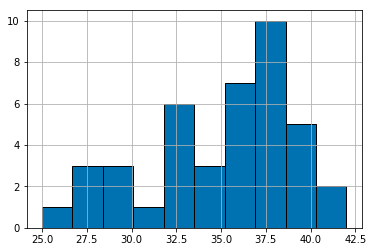

In [21]:
# plot a histogram of minutes played
three_p_subset.minutes_played.hist(ec = 'black');


For simplicity's sake, assume a Uniform prior distribution for the number of seconds Steph Curry will play in a game. We'll then model the number of 3-point shots Steph Curry takes with a Poisson distribution based on the posterior number of seconds he is expected to play. Finally, we'll model the number of shots he is expected to make with a Binomial distribution, based on the posterior number of shots he is expected to take and the collected data on shot success rate.

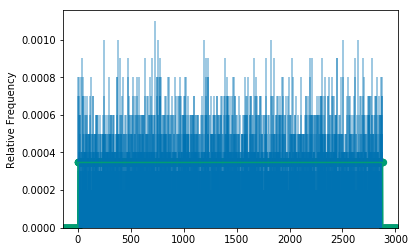

In [4]:
# import the symbulate package
from symbulate import *
%matplotlib inline

# simulate prior for seconds played
seconds_sim = RV(DiscreteUniform(a=0, b=2880)).sim(10000)
seconds_sim.plot()
DiscreteUniform(a=0, b=2880).plot()

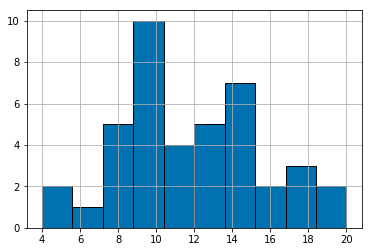

In [22]:
# histogram of three point attempts
three_p_subset.ThreePointAttempted.hist(ec = 'black')


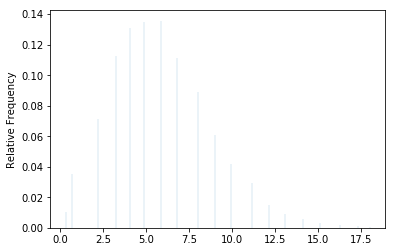

In [31]:
def binomial_for_shots():
    # since we know Steph is fairly consistent in his three-point shooting, we'll use a Beta prior distribution centered 
    # at .5 with somewhat small variance.
    p = Beta(a=6, b=6).draw()
    # we'll also need a prior distribution for the number of minutes Steph will play in a game. Steph is a starter for the 
    # Warriors and tends to play for most of the game, and each game is 48 minutes long without overtime. It is unlikely for a
    # player to play the whole game, but also unlikely that Steph will play less than half the game. To make a prior for 
    # minutes played, we'll use a Gamma distribution centered at 36 (three-quarters of a regulation NBA game), with moderate 
    # variance.
    m = round(Gamma(shape=36, rate=1).draw())
    # the number of shots curry attempts, and therefore how many he makes in a game, depends both on the probability that the
    # shot lands and the number of minutes he plays in the game. We will approximate the number of shots Steph will attempt
    # using a Poisson distribution, thinking of the number of shots he will take per minute (as a rate).
    # We'll approximate this rate using the prior information.
    
    Sa = Poisson().draw()
    x = Binomial(n, p).draw()
    return x

X = RV(ProbabilitySpace(binomial_for_shots))
X.sim(10000).plot(jitter=True, alpha=0.1) 

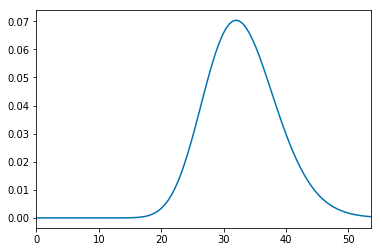

In [61]:
Gamma(shape=33, rate=1).plot()
